# Descubriendo Exoplanetas

## Objetivo

Construir un modelo de Machine Learning que detecte los planetas confirmados. Se espera generar un modelo de Machine Learning que pueda automatizar el proceso de identificar qué candidatos son exoplanetas confirmados y cuales no.

## Identificación y preparación de datos

La variable objetivo es `koi_disposition`, la cual corresponde la categoria del exoplaneta (candidato, falso positivo, no disposicionado o confirmado).

### Varibles que presentan un valor promedio muy distinto

In [1]:
import pandas as pd

In [3]:
exop_df = pd.read_csv("/content/exoplanetas.csv")

In [ ]:
exop_df.isna().sum()

In [5]:
exop_confirmed = exop_df.loc[exop_df['koi_disposition'] == 'CONFIRMED']

In [6]:
exop_confirmed_mean = exop_confirmed.mean(numeric_only=True)

In [7]:
exop_falsepos = exop_df.loc[exop_df['koi_disposition'] == 'FALSE POSITIVE']

In [8]:
exop_falsepos_mean = exop_falsepos.mean(numeric_only=True)

In [9]:
pd.concat([exop_confirmed_mean[1:], exop_falsepos_mean[1:]], axis=1, keys=['CONFIRMED', 'FALSE POSITIVE'])

,CONFIRMED,FALSE POSITIVE
koi_fpflag_nt,0.009444,0.308505
koi_fpflag_ss,0.011667,0.476027
koi_fpflag_co,0.003333,0.403253
koi_fpflag_ec,0.000556,0.249144
koi_period,26.451343,66.103066
koi_period_err1,0.000190,0.002556
koi_period_err2,-0.000190,-0.002556
koi_time0bk,156.532602,166.012645
koi_time0bk_err1,0.004084,0.010165
koi_time0bk_err2,-0.004084,-0.010165


Mediante la tabla anterior se puede comparar las medias de los exoplanetas confirmados y falsos positivos. Las variables que presentan mayores diferencia (bajo el criterio de que uno de los promedios sea superior al doble que el otro) son: 
* `koi_period` (y sus variables de certeza, `koi_period_err1` & `koi_period_err2`)
* `koi_impact` + variables de certeza
* `koi_depth` + variables de certeza
* `koi_prad` + variables de certeza 
* `koi_insol`+ variables de certeza
* `koi_model_snr`

Las variables `koi_fpflag_nt`, `koi_fpflag_ss`, `koi_fpflag_co` y `koi_fpflag_ec`, tienen una diferencia de promedio elevada tambien, pero estos al ser True o False, los encuentro relevante para el modelo.

### Reducción de cantidad de variables

Las variables finales son las que no tienen una diferencia de promedio grande (las que se mencionan en el punto anterior), a estas se le escoge una de las variables de certeza (la mayoria de estas son iguales solo con signo opuesto), por comodidad se escoge la positiva. En caso de que no sean iguales, se selecciona la que tiene menor diferencia.

In [10]:
exop_df_reduced = exop_df[['koi_disposition', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
                          'koi_time0bk', 'koi_time0bk_err1', 'koi_duration', 'koi_duration_err1', 'koi_teq',
                          'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_slogg', 'koi_slogg_err2',
                          'koi_srad', 'koi_srad_err1', 'ra', 'dec', 'koi_kepmag']].copy()

### Codificación de variable

Como la variable `koi_disposition` es un *string*, se le debe codificar asignandole un entero unico a cada valor. Para este caso, los `'CONFIRMED'` equivalen a 0, `'FALSE POSITIVE'` a 1 y `'CANDIDATE'` a 2.

In [11]:
exop_df_reduced['koi_disposition'].replace('CONFIRMED', int(0), inplace=True)
exop_df_reduced['koi_disposition'].replace('FALSE POSITIVE', int(1), inplace=True)
exop_df_reduced['koi_disposition'].replace('CANDIDATE', int(2), inplace=True)

In [ ]:
exop_df_reduced

## Entrenamiento y optimización del modelo

### Construcción de set de datos de entrenamiento y prueba

Separar el dataset en 80% de los datos para entrenar y 20% para testear

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
exop_df_reduced_X = exop_df_reduced.drop(['koi_disposition'], axis=1)
exop_df_reduced_y = exop_df_reduced['koi_disposition']

In [25]:
x_train, x_test, y_train, y_test = train_test_split(exop_df_reduced_X, exop_df_reduced_y, test_size=0.2, random_state=88)

### Entrenamiento

In [16]:
from sklearn.ensemble import RandomForestClassifier
from pprint import pprint

In [26]:
rf_model = RandomForestClassifier(random_state=88)
print('Parametros utilizados (defaults): ')
pprint(rf_model.get_params())

Parametros utilizados (defaults): 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 88,
 'verbose': 0,
 'warm_start': False}


In [27]:
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=88)

Metrica para medir desempeño: **accuracy**

In [28]:
from sklearn.metrics import accuracy_score

In [29]:
accuracy_score(y_test, rf_model.predict(x_test))

0.8892065761258041

### Optimizar hiperparámetros mediante `RandomizedSearchCV`

In [43]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

In [44]:
random_grid = {
    'max_depth': [int(x) for x in np.linspace(10, 100, num = 10)],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 5, 10],
    'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]
}

In [45]:
rf_eval = RandomForestClassifier(random_state=88)

In [46]:
random_search = RandomizedSearchCV(estimator=rf_eval, param_distributions=random_grid, n_iter = 100, cv=3, random_state=88, n_jobs=-1, verbose=2)

In [47]:
random_search.fit(x_train, y_train)
random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'max_depth': 90,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 400}

### Re-entrenamiento usando nuevos hiperparámetros

In [48]:
rf_opt = RandomForestClassifier(max_depth=90, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=88)

In [49]:
rf_opt.fit(x_train, y_train)

RandomForestClassifier(max_depth=90, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=400, random_state=88)

In [50]:
y_pred = rf_opt.predict(x_test)

In [51]:
accuracy_score(y_test, y_pred)

0.8906361686919227

Con los nuevos hiperparámetros, se tiene una mejora de un 0,14%

## Evaluación del modelo

### Métricas

In [52]:
from sklearn.metrics import classification_report

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.81      0.79       344
           1       0.98      1.00      0.99       717
           2       0.81      0.75      0.78       338

    accuracy                           0.89      1399
   macro avg       0.86      0.85      0.85      1399
weighted avg       0.89      0.89      0.89      1399



Situándonos en el caso de que un **candidato** corresponda a un nuevo valor a clasificar, y este resulta ser clasificado como confimado por el modelo, se tiene un **77%** de seguridad de que este sea un exoplaneta, lo que vendria siendo la precisión del modelo para etiquetar correctamente planetas como confirmado.

### Matriz de confusión

In [63]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

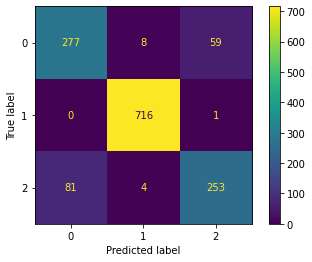

In [64]:
cm = confusion_matrix(y_test, y_pred, labels=rf_opt.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_opt.classes_)
disp.plot()
plt.show()

## What if...?

En esta sección se realiza las mismas tareas del desafío pero con nuevas varibles, como por ejemplo, usar las columnas que tienen mayor diferencia de promedio o estandarizar los valores de las columnas a utilizar. Se realiza esto con el fin de ver de ver las diferencias que existe y si hay una mejora respecto al modelo anterior.

### 1. Estandarización de las variables

#### Usando RF inicial

In [67]:
from sklearn.preprocessing import StandardScaler

In [68]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(x_train)
test_scaled = scaler.transform(x_test)

In [69]:
rf_model.fit(train_scaled, y_train) #RF inicial, usando los parametros default + random_state = 88

RandomForestClassifier(random_state=88)

In [70]:
accuracy_score(y_test, rf_model.predict(test_scaled))

0.8884917798427449

Respecto al modelo original (sin estandarizar los valores), se tiene que este decrementa un 0,07%

#### Optimizar hiperparámetros y re-entrenamiento

Se utilizan la misma configuración de posibles hiperparámetros óptimos, definidos en el modelo inicial.



In [71]:
random_search.fit(train_scaled, y_train)
random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'max_depth': 90,
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 400}

In [78]:
rf_standar_opt = RandomForestClassifier(max_depth=90, min_samples_leaf=2, min_samples_split=10, n_estimators=400, random_state=88)

In [79]:
rf_standar_opt.fit(train_scaled, y_train)

RandomForestClassifier(max_depth=90, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=400, random_state=88)

In [80]:
y_pred = rf_standar_opt.predict(test_scaled)

In [81]:
accuracy_score(y_test, y_pred)

0.8906361686919227

Con los nuevos hiperparámetros, se tiene una mejora de un 0,21%. Respecto al modelo original, presentan el mismo `accuracy`, se puede inferir que no se requiere en este caso estandarizar los datos si se encuentra la misma configuracion de hiperpárametros.

### 2. Cambiar las columnas por las descartadas

Se realiza esto con la hipótesis de que al usar los valores con gran diferencia de promedio, el modelo le resulta más fácil distinguir entre un planeta confirmado vs un falso positivo.

In [82]:
exop_df_reduced_hm = exop_df.drop(['koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
                                    'koi_time0bk', 'koi_time0bk_err1', 'koi_duration', 'koi_duration_err1', 'koi_teq',
                                    'koi_tce_plnt_num', 'koi_steff', 'koi_steff_err1', 'koi_slogg', 'koi_slogg_err2',
                                    'koi_srad', 'koi_srad_err1', 'ra', 'dec', 'koi_kepmag'], axis=1)

In [ ]:
exop_df_reduced_hm

In [84]:
exop_df_reduced_hm['koi_disposition'].replace('CONFIRMED', int(0), inplace=True)
exop_df_reduced_hm['koi_disposition'].replace('FALSE POSITIVE', int(1), inplace=True)
exop_df_reduced_hm['koi_disposition'].replace('CANDIDATE', int(2), inplace=True)

In [85]:
exop_df_reduced_hm_X = exop_df_reduced_hm.drop(['koi_disposition'], axis=1)
exop_df_reduced_hm_y = exop_df_reduced_hm['koi_disposition']

In [86]:
x_train_hm, x_test_hm, y_train_hm, y_test_hm = train_test_split(exop_df_reduced_hm_X, exop_df_reduced_hm_y, test_size=0.2, random_state=88)

#### Entrenamiento y optimización

In [87]:
rf_hm_model = RandomForestClassifier(random_state=88)
print('Parametros utilizados (defaults): ')
pprint(rf_model.get_params())

Parametros utilizados (defaults): 
{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 88,
 'verbose': 0,
 'warm_start': False}


In [89]:
rf_hm_model.fit(x_train_hm, y_train_hm)

RandomForestClassifier(random_state=88)

In [91]:
accuracy_score(y_test_hm, rf_hm_model.predict(x_test_hm))

0.771265189421015

Se utilizan la misma configuración de posibles hiperparámetros óptimos, definidos en el modelo inicial.



In [92]:
random_search.fit(x_train_hm, y_train_hm)
random_search.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'max_depth': 40,
 'min_samples_leaf': 4,
 'min_samples_split': 3,
 'n_estimators': 200}

In [93]:
rf_opt_hm = RandomForestClassifier(max_depth=40, min_samples_leaf=4, min_samples_split=3, n_estimators=200, random_state=88)

In [ ]:
rf_opt_hm.fit(x_train_hm, y_train_hm)

In [95]:
accuracy_score(y_test_hm, rf_opt_hm.predict(x_test_hm))

0.7698355968548963

Con los nuevos hiperparámetros, se tiene una reducción de un 0,14% frente al uso de los parametros iniciales (defaults). Además, su `accuracy` es inferior a los modelos anteriores.

Este resultado da a lugar que la hipótesis planteada no se cumple. Aunque existen posibles mejoras a los modelos planteados, como:

* Aumentar la cantidad de iteraciones y cross-validation de la técnica `RandomizedSearchCV`
* Utilizar otra técnica de optimización como `GridSearchCV`
* Agregar nuevos posibles valores de hiperparámetros a probar.
* En caso de querer comprobar nuevamente la hipótesis, se puede mantener las variables que tengan promedio elevado, pero descartando una de las columnas de certeza asociada, como también incluir las variables de `koi_fpflag_nt`, `koi_fpflag_ss`, `koi_fpflag_co` y `koi_fpflag_ec`.